In [1]:
# Comparing the single and double Gaussian distributions for different defocus values
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import math

In [2]:
# A function to choose different LEEM parameters
def choose_LEEM_type(LEEM_type_str, aberration_corrected_bool = False):
    global E, E_0, C_c, C_cc, C_3c, C_3, C_5, alpha_ap, alpha_ill, \
        delta_E, M_L, lamda, lamda_0, q_ill, q_ap, LEEM_type, aberration_corrected
    LEEM_type = LEEM_type_str
    aberration_corrected = aberration_corrected_bool
    
    if LEEM_type == "IBM":
        if aberration_corrected == False:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 10  # eV  Energy at the sample
            
            C_c = -0.075  # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 23.09 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -59.37  # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0.345  # m  Third Order Spherical Aberration Coefficient
            C_5 = 39.4  # m  Fifth Order Spherical Aberration Coefficient
            
            alpha_ap = 2.34e-3  # rad Aperture angle
            alpha_ill = 0.1e-3  # rad Illumination Divergence Angle
            
            delta_E = 0.25  # eV  Energy Spread
            M_L = 0.653  # Lateral Magnification
            print("IBM nac chosen.")
            
        elif aberration_corrected == True:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 10  # eV  Energy at the sample
            
            C_c = 0  # m   Second Rank Chromatic Aberration Coefficient
            C_cc = 27.9 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -67.4 # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0  # m   Spherical Aberration Coefficient
            C_5 = 92.8
        
            alpha_ap = 7.37e-3  # rad Aperture angle
            alpha_ill = 0.1e-3  # rad Illumination Divergence Angle
        
            delta_E = 0.25  # eV  Energy Spread
            M_L = 0.653  # Lateral Magnification
            print("IBM ac chosen.")
            
        lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E)
        lamda_0 = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E_0)
    
        q_ap = alpha_ap/lamda
        q_ill = alpha_ill/lamda
        
    elif LEEM_type == "Energy dependent":
        if aberration_corrected == False:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 11.5 # eV  Energy at the sample ##########CUSTOMIZABLE INPUT##########
            kappa = np.sqrt(E/E_0)
            
            C_c = -0.0121 * kappa**(1/2) + 0.0029 # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 0.5918 * kappa**(3/2) - 87.063 # m   Third Rank Chromatic Aberration Coefficient
            C_3c = -1.2141 * kappa**(3/2) + 169.41  # m   Forth Rank Chromatic Aberration Coefficient
            
            C_3 = 0.0297 * kappa**(1/2) + 0.1626  # m  Third Order Spherical Aberration Coefficient
            C_5 = 0.6223 * kappa**(3/2) - 79.305  # m  Fifth Order Spherical Aberration Coefficient
            
            delta_E = 0.25  # eV  Energy Spread
            alpha_ill = 0.1e-3  # rad Illumination divergence angle
            M_L = 0.653  # Lateral Magnification
            
            lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E) # in metre
            alpha_ap = (lamda/C_3)**(1/4) # rad Aperture angle for optimal resolution
            
            print("Custom nac LEEM at E_0 = " + str(E_0) + " eV chosen.")
            
        if aberration_corrected == True:
            E = 15010  # eV  Nominal Energy After Acceleration
            E_0 = 11.5 # eV  Energy at the sample
            kappa = np.sqrt(E/E_0)
            
            C_c = 0 # m  Second Rank Chromatic Aberration Coefficient
            C_cc = 0.5984 * kappa**(3/2) - 84.002 # m   Third Rank Chromatic Aberration Coefficient 
            C_3c = -1.1652 * kappa**(3/2) + 153.58  # m   Forth Rank Chromatic Aberration Coefficient  
            
            C_3 = 0  # m  Third Order Spherical Aberration Coefficient
            C_5 = 0.5624 * kappa**(3/2) - 16.541  # m  Fifth Order Spherical Aberration Coefficient
            
            delta_E = 0.25  # eV  Energy Spread
            alpha_ill = 0.1e-3  # rad Illumination divergence angle
            M_L = 0.653  # Lateral Magnification
            
            lamda = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E) # in metre
            alpha_ap = (3/2*lamda/C_5)**(1/6) # rad Aperture angle for optimal resolution
            
            print("Custom ac LEEM at E_0 = " + str(E_0) + " eV chosen.")   
        
        lamda_0 = 6.6261e-34 / np.sqrt(2 * 1.6022e-19 * 9.1095e-31 * E_0) # in metre
        
        q_ap = alpha_ap/lamda
        q_ill = alpha_ill/lamda


# A function to set different defocus values
def choose_defocus(defocus_type, value = 0):
    global delta_z
    if defocus_type == "In-focus":
        delta_z = 0
        print("In-focus chosen.")
    elif defocus_type == "Scherzer defocus":
        delta_z = np.sqrt(3/2*C_3*lamda)
        print("Scherzer defocus chosen.")
    elif defocus_type == "A-Phi Scherzer defocus":
        delta_z = np.sqrt(9/64*C_5*lamda**2)
        print("A-Phi Scherzer defocus chosen.")
    elif defocus_type == "custom":
        delta_z = value

In [3]:
object_size = 400               # simulating object size in nm
simulating_steps = 1 + 2**15    # total simulating steps
# An array of points in the x space
x_array = (np.linspace(-object_size/2, object_size/2, simulating_steps) + object_size/simulating_steps)*1e-9

In [4]:
# A function to choose different sample object function
def create_object(object_type_str, k = 1):
    global object_type, object_function, object_amplitude, object_phase
    object_type = object_type_str
    if object_type == "Step amplitude object":
    # Creating an 1:1/sqrt(2) step amplitude object whose phase is uniformly set to 0
        object_phase = np.zeros_like(x_array)
        
        object_amplitude = np.ones_like(x_array)
        
        for counter, element in enumerate(x_array):
            if element > 0:
                object_amplitude[counter] = 1/np.sqrt(2)
    
    if object_type == "Error function amplitude object":
    # Creating an error function amplitude object whose phase is uniformly set to 0         
        object_amplitude = np.ones_like(x_array)
        
        object_phase = np.zeros_like(x_array)
        
        for counter, element in enumerate(x_array):
            object_amplitude[counter] = math.erf(element*1e8)/2*(1-1/np.sqrt(2)) + (1+1/np.sqrt(2))/2
            
        object_amplitude = object_amplitude[::-1]
    
    if object_type == "Step phase object":
    # Creating a k.pi step phase object whose amplitude is uniformly set to 1        
        object_amplitude = np.ones_like(x_array)
        
        object_phase = np.zeros_like(x_array)
        
        for counter, element in enumerate(x_array):
            if element > 0:
                object_phase[counter] = k * np.pi
     
    
    if object_type == "Error function phase object":
    # Creating an error function phase object whose amplitude is uniformly set to 1
        object_amplitude = np.ones_like(x_array)
        
        object_phase = np.ones_like(x_array)
        
        for counter, element in enumerate(x_array):
            object_phase[counter] = (math.erf(element*1e8)+1)/2*k*np.pi

    # Object function
    object_function = np.multiply(object_amplitude, np.exp(1j * object_phase)) 

In [5]:
choose_LEEM_type("Energy dependent", aberration_corrected_bool = False)
create_object("Step phase object", k = 1)


# The object image is reversed through the lens
object_function_reversed = object_function[::-1] 

Custom nac LEEM at E_0 = 11.5 eV chosen.


In [6]:
# Creating an array of different cut-off frequencies

delta_z_series = np.append(np.linspace(-9*1e-6, -4*1e-6, 6), np.linspace(-3.5*1e-6, 3.5*1e-6, 25))
delta_z_series = np.append(delta_z_series, np.linspace(4*1e-6, 10*1e-6, 7))
'''
delta_z_series = np.linspace(-5*1e-6, 5*1e-6, 3)
'''

'\ndelta_z_series = np.linspace(-5*1e-6, 5*1e-6, 3)\n'

In [7]:
# Initialising the series of function I_1(x) and I_2(x) at different values of q_ap
matrixI1 = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
matrixI2 = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
matrixI3 = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)

In [8]:
# A function to calculate the image for single Gaussian distribution
def Image1Gauss(delta_z, delta_z_index):    
    matrixI = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
    # The Fourier Transform of the Object Wave Function
    F_object_function = np.fft.fft(object_function_reversed, simulating_steps) * (1 / simulating_steps)
    # Shifting this to the centre at 0
    F_object_function = np.fft.fftshift(F_object_function)
    # An array of points in the q space, in SI unit
    q = 1 / (simulating_steps* (x_array[1] - x_array[0])) * np.arange(0, simulating_steps, 1)
    # Shifting the q array to centre at 0 
    q = q - np.max(q) / 2
    
    # Taking into account the effect of the contrast aperture    
    a = np.sum(np.abs(q) <= q_ap)
    if len(q) > a:
        min_index = int(np.ceil(simulating_steps / 2 + 1 - (a - 1) / 2))
        max_index = int(np.floor(simulating_steps / 2 + 1 + (a + 1) / 2))
        q = q[min_index:max_index]
        F_object_function = F_object_function[min_index:max_index]
        
    # Arrays for the calculation of the double integration 
    Q, QQ = np.meshgrid(q, q)
    F_obj_q, F_obj_qq = np.meshgrid(F_object_function, np.conj(F_object_function))
    
    # The modifying function of zeroth-order
    R_0 = np.exp(1j*2*np.pi*(C_3*lamda**3 * (Q**4 - QQ**4)/4 + C_5*lamda**5 *(
        Q**6 - QQ**6)/6 - delta_z*lamda*(Q**2 - QQ**2)/2))
    
    delta_E = 0.2424 # eV
    sigma_E = delta_E/(2*np.sqrt(2*np.log(2)))
    sigma_ill = q_ill/(2*np.sqrt(2*np.log(2)))
    
    a_1 = C_3*lamda**3 *(Q**3 - QQ**3) + C_5*lamda**5 * (Q**5 - QQ**5) - delta_z*lamda*(Q - QQ)
    
    b_1 = 1/2*C_c*lamda*(Q**2 - QQ**2)/E + 1/4*C_3c*lamda**3*(Q**4 - QQ**4)/E
    b_2 = 1/2*C_cc*lamda*(Q**2 - QQ**2)/E**2
    
    # The envelop function by source extension
    E_s = np.exp(-2*np.pi**2 *sigma_ill**2 *a_1**2)
    
    # The purely chromatic envelop functions
    E_cc = (1 - 1j*4*np.pi*b_2*sigma_E**2)**(-1/2)
    E_ct = E_cc * np.exp(-2*np.pi**2 *E_cc**2 *sigma_E**2 *b_1**2)
    
    AR = np.multiply(np.multiply(np.multiply(np.multiply(F_obj_q, F_obj_qq), R_0), E_s), E_ct)
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + 2 * (
                    AR[j][i] * np.exp(1j * 2 * np.pi * (Q[j][i] - QQ[j][i]) * x_array)).real
        

    matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + np.trace(AR) * np.ones_like(x_array)

    return matrixI

with Parallel(n_jobs=-1, verbose=50, max_nbytes="50M") as parallel:
    parallelResult = parallel(delayed(Image1Gauss)(delta_z, delta_z_index) for delta_z_index, delta_z in enumerate(delta_z_series))

for mat in parallelResult:
    matrixI1 = matrixI1 + mat

matrixI1 = np.abs(matrixI1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

In [9]:
# A function to calculate the image for double Gaussian distribution 
def Image3Gauss(delta_z, delta_z_index):
    matrixI = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
    # The Fourier Transform of the Object Wave Function
    F_object_function = np.fft.fft(object_function_reversed, simulating_steps) * (1 / simulating_steps)
    # Shifting this to the centre at 0
    F_object_function = np.fft.fftshift(F_object_function)
    # An array of points in the q space, in SI unit
    q = 1 / (simulating_steps* (x_array[1] - x_array[0])) * np.arange(0, simulating_steps, 1)
    # Shifting the q array to centre at 0 
    q = q - np.max(q) / 2
    
    # Taking into account the effect of the contrast aperture    
    a = np.sum(np.abs(q) <= q_ap)
    if len(q) > a:
        min_index = int(np.ceil(simulating_steps / 2 + 1 - (a - 1) / 2))
        max_index = int(np.floor(simulating_steps / 2 + 1 + (a + 1) / 2))
        q = q[min_index:max_index]
        F_object_function = F_object_function[min_index:max_index]
        
    # Arrays for the calculation of the double integration 
    Q, QQ = np.meshgrid(q, q)
    F_obj_q, F_obj_qq = np.meshgrid(F_object_function, np.conj(F_object_function))
    
    # The modifying function of zeroth-order
    R_0 = np.exp(1j*2*np.pi*(C_3*lamda**3 * (Q**4 - QQ**4)/4 + C_5*lamda**5 *(
        Q**6 - QQ**6)/6 - delta_z*lamda*(Q**2 - QQ**2)/2))
    
    sigma_E1 = 0.0531  # eV
    sigma_E2 = 0.1991  # eV
    sigma_E3 = 0.0962  # eV
    epsilon_1 = -0.03925 # eV
    epsilon_2 = -0.3382  # eV
    epsilon_3 = -0.1438  # eV
    mu_1 = 0.28682
    mu_2 = 0.33146
    mu_3 = 0.38173
    
    sigma_ill = q_ill/(2*np.sqrt(2*np.log(2)))
    
    a_1 = C_3*lamda**3 *(Q**3 - QQ**3) + C_5*lamda**5 * (Q**5 - QQ**5) - delta_z*lamda*(Q - QQ)
    
    b_1 = 1/2*C_c*lamda*(Q**2 - QQ**2)/E + 1/4*C_3c*lamda**3*(Q**4 - QQ**4)/E
    b_2 = 1/2*C_cc*lamda*(Q**2 - QQ**2)/E**2
    
    c_1 = b_1 - 1j*epsilon_1/(2*np.pi*sigma_E1**2)
    c_2 = b_1 - 1j*epsilon_2/(2*np.pi*sigma_E2**2)
    c_3 = b_1 - 1j*epsilon_3/(2*np.pi*sigma_E3**2)
    
    # The envelop function by source extension
    E_s = np.exp(-2*np.pi**2 *sigma_ill**2 *a_1**2)
    
    ## The chromatic envelop functions for the 1st Gaussian distribution  
    E_cc1 = (1 - 1j*4*np.pi*b_2*sigma_E1**2)**(-1/2)
    E_ct1 = E_cc1 * np.exp(-2*np.pi**2 *E_cc1**2 *sigma_E1**2 *c_1**2) * np.exp(- epsilon_1**2/(2*sigma_E1**2))
    
    ## The chromatic envelop functions for the 2nd Gaussian distribution  
    E_cc2 = (1 - 1j*4*np.pi*b_2*sigma_E2**2)**(-1/2)
    E_ct2 = E_cc2 * np.exp(-2*np.pi**2 *E_cc2**2 *sigma_E2**2 *c_2**2) * np.exp(- epsilon_2**2/(2*sigma_E2**2))
    
    ## The chromatic envelop functions for the 3rd Gaussian distribution  
    E_cc3 = (1 - 1j*4*np.pi*b_2*sigma_E3**2)**(-1/2)
    E_ct3 = E_cc3 * np.exp(-2*np.pi**2 *E_cc3**2 *sigma_E3**2 *c_3**2) * np.exp(- epsilon_3**2/(2*sigma_E3**2))
    
    # The total chromatic envelop functions
    E_ctot = mu_1*E_ct1 + mu_2*E_ct2 + mu_3*E_ct3
    
    AR = np.multiply(np.multiply(np.multiply(np.multiply(F_obj_q, F_obj_qq), R_0), E_s), E_ctot)
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + 2 * (
                    AR[j][i] * np.exp(1j * 2 * np.pi * (Q[j][i] - QQ[j][i]) * x_array)).real
        

    matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + np.trace(AR) * np.ones_like(x_array)

    return matrixI

with Parallel(n_jobs=-1, verbose=50, max_nbytes="50M") as parallel:
    parallelResult = parallel(delayed(Image3Gauss)(delta_z, delta_z_index) for delta_z_index, delta_z in enumerate(delta_z_series))

for mat in parallelResult:
    matrixI2 = matrixI2 + mat

matrixI2 = np.abs(matrixI2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

In [10]:
# A function to calculate the image for the 1st Gaussian distribution 
def Image3GaussC1(delta_z, delta_z_index):
    matrixI = np.zeros((len(x_array), len(delta_z_series)), dtype=complex)
    # The Fourier Transform of the Object Wave Function
    F_object_function = np.fft.fft(object_function_reversed, simulating_steps) * (1 / simulating_steps)
    # Shifting this to the centre at 0
    F_object_function = np.fft.fftshift(F_object_function)
    # An array of points in the q space, in SI unit
    q = 1 / (simulating_steps* (x_array[1] - x_array[0])) * np.arange(0, simulating_steps, 1)
    # Shifting the q array to centre at 0 
    q = q - np.max(q) / 2
    
    # Taking into account the effect of the contrast aperture    
    a = np.sum(np.abs(q) <= q_ap)
    if len(q) > a:
        min_index = int(np.ceil(simulating_steps / 2 + 1 - (a - 1) / 2))
        max_index = int(np.floor(simulating_steps / 2 + 1 + (a + 1) / 2))
        q = q[min_index:max_index]
        F_object_function = F_object_function[min_index:max_index]
        
    # Arrays for the calculation of the double integration 
    Q, QQ = np.meshgrid(q, q)
    F_obj_q, F_obj_qq = np.meshgrid(F_object_function, np.conj(F_object_function))
    
    # The modifying function of zeroth-order
    R_0 = np.exp(1j*2*np.pi*(C_3*lamda**3 * (Q**4 - QQ**4)/4 + C_5*lamda**5 *(
        Q**6 - QQ**6)/6 - delta_z*lamda*(Q**2 - QQ**2)/2))
    
    sigma_E1 = 0.0531  # eV
    epsilon_1 = -0.03925
    mu_1 = 1 #0.28682
    
    sigma_ill = q_ill/(2*np.sqrt(2*np.log(2)))
    
    a_1 = C_3*lamda**3 *(Q**3 - QQ**3) + C_5*lamda**5 * (Q**5 - QQ**5) - delta_z*lamda*(Q - QQ)
    
    b_1 = 1/2*C_c*lamda*(Q**2 - QQ**2)/E + 1/4*C_3c*lamda**3*(Q**4 - QQ**4)/E
    b_2 = 1/2*C_cc*lamda*(Q**2 - QQ**2)/E**2
    
    c_1 = b_1 - 1j*epsilon_1/(2*np.pi*sigma_E1**2)
    
    # The envelop function by source extension
    E_s = np.exp(-2*np.pi**2 *sigma_ill**2 *a_1**2)
    
    ## The chromatic envelop functions for the 1st Gaussian distribution  
    E_cc1 = (1 - 1j*4*np.pi*b_2*sigma_E1**2)**(-1/2)
    E_ct1 = E_cc1 * np.exp(-2*np.pi**2 *E_cc1**2 *sigma_E1**2 *c_1**2) * np.exp(- epsilon_1**2/(2*sigma_E1**2))
    
    E_ctot = mu_1*E_ct1 
    
    AR = np.multiply(np.multiply(np.multiply(np.multiply(F_obj_q, F_obj_qq), R_0), E_s), E_ctot)
    for i in range(len(q)):
        for j in range(i + 1, len(q)):
            matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + 2 * (
                    AR[j][i] * np.exp(1j * 2 * np.pi * (Q[j][i] - QQ[j][i]) * x_array)).real
        

    matrixI[:, delta_z_index] = matrixI[:, delta_z_index] + np.trace(AR) * np.ones_like(x_array)

    return matrixI

with Parallel(n_jobs=-1, verbose=50, max_nbytes="50M") as parallel:
    parallelResult = parallel(delayed(Image3GaussC1)(delta_z, delta_z_index) for delta_z_index, delta_z in enumerate(delta_z_series))

for mat in parallelResult:
    matrixI3 = matrixI3 + mat

matrixI3 = np.abs(matrixI3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  3

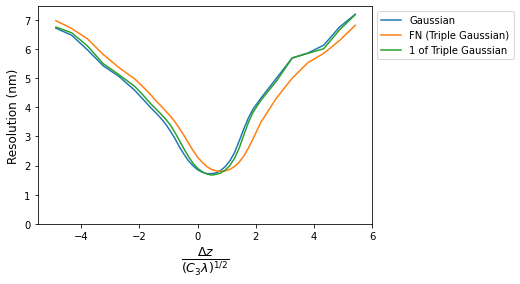

In [39]:
# A function returning a list of resolutions corresponding to different defocus values
def Find_R_list(matrixI_input):
    resolution_list = []
    half_steps = int(simulating_steps/2)
    
    for i in range(len(delta_z_series)):
        matrixI = matrixI_input[:, i]
        if object_type == "Step amplitude object" or object_type == "Error function amplitude object":
            # Starting from the centre and find the local minimum to the right of the central point
            I_min = matrixI[half_steps]
            for j in range(1, half_steps):
                if matrixI[half_steps+j] < I_min:
                    I_min = matrixI[half_steps+j]
                else:
                    idx_min = half_steps+j-1
                    break
                
            # Starting from the centre and find the local maximum to the left of the central point
            I_max = matrixI[half_steps]
            for j in range(1, half_steps):
                if matrixI[half_steps-j] > I_max:
                    I_max = matrixI[half_steps-j]            
                else:
                    idx_max = half_steps-j+1
                    break
            
            I_100_index = idx_max + np.argmin(np.abs(matrixI[idx_max:idx_min] - 1))
            I_100 = matrixI[I_100_index]
            I_0_index = idx_max + np.argmin(np.abs(matrixI[idx_max:idx_min] - 1/2))
            I_0 = matrixI[I_0_index]
            
            I_84 = I_0 + (I_100 - I_0)*84/100
            I_16 = I_0 + (I_100 - I_0)*16/100
            
            I_84_index = idx_max + np.argmin(np.abs(matrixI[idx_max:idx_min] - I_84))
            x_84 = x_array[I_84_index]
            I_16_index = idx_max + np.argmin(np.abs(matrixI[idx_max:idx_min] - I_16))
            x_16 = x_array[I_16_index]
            resolution = x_16 - x_84
        
        if object_type == "Step phase object" or object_type == "Error function phase object":
            # Finding the local minimum around the central point
            I_min = matrixI[half_steps]
            for j in range(1, half_steps):
                if matrixI[half_steps+j] <= I_min:
                    I_min = matrixI[half_steps+j]
                else:
                    idx_min = half_steps+j-1
                    break
            
            current_min_idx = idx_min
            for j in range(1, half_steps):
                if matrixI[current_min_idx-j] <= I_min:
                    I_min = matrixI[current_min_idx-j]
                else:
                    idx_min = current_min_idx-j+1
                    break
            
            # Finding the local maximum to the right of this minimum
            I_right = matrixI[idx_min]
            for j in range(1, half_steps):
                if matrixI[idx_min+j] >= I_right:
                    I_right = matrixI[idx_min+j]
                else:
                    idx_right = idx_min+j-1
                    break
                
            # Finding the local maximum to the left of this minimum
            I_left = matrixI[idx_min]
            for j in range(1, half_steps):
                if matrixI[idx_min-j] >= I_left:
                    I_left = matrixI[idx_min-j]            
                else:
                    idx_left = idx_min-j+1
                    break
            
            I_50 = (1 + I_min)/2
            
            I_50left_index = idx_left + np.argmin(np.abs(matrixI[idx_left:idx_min] - I_50))
            x_50left = x_array[I_50left_index]
            I_50right_index = idx_min + np.argmin(np.abs(matrixI[idx_min:idx_right] - I_50))
            x_50right = x_array[I_50right_index]
            resolution = (x_50right - x_50left)*1e9
            
        resolution_list.append(resolution)
        
    return resolution_list

resolution_list1 = Find_R_list(matrixI1)
resolution_list2 = Find_R_list(matrixI2)
resolution_list3 = Find_R_list(matrixI3)
    
plt.plot(delta_z_series/(C_3*lamda)**(1/2), resolution_list1, label = 'Gaussian')
plt.plot(delta_z_series/(C_3*lamda)**(1/2), resolution_list2, label = 'FN (Triple Gaussian)')
plt.plot(delta_z_series/(C_3*lamda)**(1/2), resolution_list3, label = '1 of Triple Gaussian')

plt.xlim(-5.5,6)
plt.ylim(0,)

# naming the x axis
plt.xlabel('$\\frac{\Delta z}{(C_3 \lambda)^{1/2}}$', fontsize=18)
# naming the y axis
plt.ylabel('Resolution (nm)', fontsize=12)
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
filename1 = 'R(dz) Gaussian spread ' + filename
with open(filename1, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Delta z (mu m)', 'Resolution'])
    
    for i in range(len(delta_z_series)):
        writer.writerow([round(1e6 * delta_z_series[i], 5), round(resolution_list1[i], 10)])
 
    csvfile.close()

filename2 = 'R(dz) FN spread ' + filename
with open(filename2, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Delta z (mu m)', 'Resolution'])
    
    for i in range(len(delta_z_series)):
        writer.writerow([round(1e6 * delta_z_series[i], 5), round(resolution_list2[i], 10)])
 
    csvfile.close()
    
filename3 = 'R(dz) Gauss G1 spread ' + filename
with open(filename3, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Delta z (mu m)', 'Resolution'])
    
    for i in range(len(delta_z_series)):
        writer.writerow([round(1e6 * delta_z_series[i], 5), round(resolution_list3[i], 10)])
 
    csvfile.close()